# Clustering Lyrics Using Kmeans

This module uses the lyrics_dict.json file, which contains each track with its corresponding lyrics in bag-of-words format. It trasnforms the corpus into a tf-idf sparse matrix, which will be discussed later on in the module. Finally, it clusters the lyrics. Several clustering algorithms will be explored, and the final algorithm/cluster number combination will be selected based on silhouette score, which will also be discussed.

In [38]:
import json
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import re

We first open our json file, which stores tracks as keys and a list of lyrics as values in a dictionary. 

In [39]:
with open('lyrics_dict_subset.json', 'r') as fp:
    data_json = json.load(fp)

We access a random track to see the structure of the dictionary.

In [40]:
random.choice(list(data_json.items()))

('TRANNCZ128F92F1D22',
 '[i i i i i i i i i i i i i i i  the the the the the the the the the the the the the  you  to to to to  and and and and and and and and and and  a a a a a a  it it it  in in in  my my my my my my my  is  of of of of of of of of of of of  your  that that that  do  are are  am am am am am  will  all  for for for  no  have have have have  so so  but  with with with with  what  when  like  can can can  come come  there there there there  up  oh oh  they  out out out out  if if  never  from  he he  take  would would would would  at  here  could  night  thing  right  who who  man  give give  onli onli  tri  well  an an  his  long  littl  hand  noth  light  call  home  ever ever  head  their  someth someth  insid  place place  these these  off off  old  even  without  same same  far far  tear  dead  doe  year year year year  sound  deep  understand  best  seen  after after  grow grow  scream scream  men  feet  veri  empti empti empti  king king  tire tire  sinc  yet  s

In [41]:
# make this into two lists: tracks and lyrics

tracks = list(data_json.keys())
lyrics = list(data_json.values())

## Term Frequency-Inverse Document Frequency

We want to turn our list of lyrics into a term frequency-inverse document frequency (tf-idf) sparse matrix. This is done with the following calculations.

* _term frequency_ is the number of times that word appears in the document, and it can be (but is not always) divided by the document length to normalize it.

* _inverse document frequency_ is a measure of how important a word is. It is computed using the log of the total number of documents divided by the numer of documents with the term in it.

* _tf-idf_ is the product of these two terms

(Put the mathematical formula here)

This process uses one row for each document. Columns consist of the vocabulary of the corpus. Row entries include the tf-idf weight for each word that occurs in the document. If a word does not occur, a zero is entered.

http://www.tfidf.com/

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Fortunately, there is a scikit-learn algorithm, TfidfVectorizer, that does these calculations for us. But first we need to create a list of stopwords, which will be passed as a parameter to the algorithm.

The NLTK library comes with a [number of corpora](http://www.nltk.org/howto/corpus.html#other-corpora), one of which includes stopwords in multiple languages. Since our dataset contains songs in more than one language, we combine these stopwords, along with a list of our own stopwords, to use in the TfidfVectorizer.

In [42]:
english = stopwords.words('english')
french = stopwords.words('french')
spanish = stopwords.words('spanish')
portuguese = stopwords.words('portuguese')
mine = ['yeah', 'get', 'got', 'would', 'nan', 'ca']
stop = english + french + spanish + portuguese + mine
#stop

In addition to stopwords, there are a couple of other parameters we're interested in for the TfidvVectorizer:

* **max\_df**: When building the vocabulary ignore terms that have a document frequency  higher than the given threshold (corpus-specific stop words). 

* **min\_df**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. 

* **use\_idf**: Enable inverse-document-frequency reweighting

Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [43]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)

Now we need to use our tfidf_vectorizer to fit the lyrics. We use the fit_transform method, which learns the vocabulary and idf weight, and returns a term-document matrix. Looking at the shape, we find that there are 2383 documents with a vocabulary of 4497 terms.

In [44]:
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)

print(tfidf_matrix.shape)

(2383, 6)


In [45]:
tfidf_matrix

<2383x6 sparse matrix of type '<class 'numpy.float64'>'
	with 4659 stored elements in Compressed Sparse Row format>

## Kmeans Clustering

Now that we have our TF-IDF, we can move forward with clustering. We'll first cluster the documents using Kmeans. We'll use the following process to determine the optimal number of clusters:

1. Calculate the silhouette coefficient
    
From http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html:
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of."
    
    The silhouette score is the mean silhouette score over all samples. The score ranges from -1 to 1. We want a score that's close to 1.
    
From http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html:
    
    Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
    
2.  After look at the sillhouette average across a range of clusters, we'll select numbers of clusters that look promising and look at the silhouette plots. This will give us a better understanding of how well our data is clustered. We'll also look at the top words in each of the clusters.


http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### Kmeans Methods

Since we're going to be using the kmeans algorithm, let's take a minute to understand what each of the functions does. We'll use a subset of 10 songs, with k=3.

The scikit Kmeans class implements the following methods:

* **fit(X[, y])** -	Compute k-means clustering.
* **fit_predict(X[, y])** -	Compute cluster centers and predict cluster index for each sample.
* **fit_transform(X[, y])** - Compute clustering and transform X to cluster-distance space.
* **get_params([deep])** - Get parameters for this estimator.
* **predict(X)** -Predict the closest cluster each sample in X belongs to.
* **score(X[, y])**	- Opposite of the value of X on the K-means objective.
* **set_params(**params)** - Set the parameters of this estimator.
* **transform(X[, y])** - Transform X to a cluster-distance space.

We'll explore m of the methods to understand their return values a little better.

Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit

In [46]:
lyric = lyrics[0:10]

# create tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(lyric)

km = KMeans(n_clusters=3, init='k-means++', random_state=3)

# does this actually do anything?
km_fit = km.fit(tfidf_matrix)
km_fit, km.fit(tfidf_matrix)

(KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0),
 KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0))

In [47]:
# these returns cluster labels
km_fit_predict = km.fit_predict(tfidf_matrix)
km_predict = km.predict(tfidf_matrix)
km_fit_predict, km_predict

(array([2, 1, 1, 1, 0, 2, 1, 1, 0, 1]), array([2, 1, 1, 1, 0, 2, 1, 1, 0, 1]))

In [48]:
# these transform x to cluster-distance space using euclidian distance and return a numpy ndarray
km_fit_transform = km.fit_transform(tfidf_matrix)
km_transform = km.transform(tfidf_matrix)
km_fit_transform, km_transform

(array([[ 1.30440569,  1.00749944,  0.43643492],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.46911983,  0.93614754,  1.2294839 ],
        [ 1.22759535,  0.85056623,  0.43643492],
        [ 1.31401415,  0.80210213,  1.24613685],
        [ 1.14286368,  0.7768557 ,  1.10562645],
        [ 0.46911983,  0.98467982,  1.32515276],
        [ 1.04422242,  0.78826696,  1.05562896]]),
 array([[ 1.30440569,  1.00749944,  0.43643492],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.88313452,  0.35461444,  0.89973583],
        [ 0.46911983,  0.93614754,  1.2294839 ],
        [ 1.22759535,  0.85056623,  0.43643492],
        [ 1.31401415,  0.80210213,  1.24613685],
        [ 1.14286368,  0.7768557 ,  1.10562645],
        [ 0.46911983,  0.98467982,  1.32515276],
        [ 1.04422242,  0.78826696,  1.05562896]]))

## Evaluating Clusters: Silhouette Scores

How do we decide how well our documents are clustered? One method is to use the silhouette coefficient. From [wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)):
    
    The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value a indicates that the object is well matched to its own cluster and badly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
    
Scikit-Learn has two functions that calculate the silhouette coefficient. 

* The function [silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) returns the mean silhouette coefficient for all samples. 

* The funciton [silhouette_samples](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) returns the silhouette coefficient for each sample. 

We'll use the silhouette_score function to compare different numbers of clusters, using euclidean distance for the metric parameter.

Next, we define the functions we'll use to compare clusters, create clusters, create the total vocabulary, and to print the clusters. The create_vocab and print_clusters have been adapted from http://brandonrose.org/clustering. The compare_clusters function was adapted from the text Python Data Science Cookbook, chapter 5.

In [49]:
# function definitions---------------------------------
def compare_clusters(lyrics, k_range, max_df, min_df, stop):    
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df,
                                       min_df=min_df,
                                       stop_words=stop,
                                       use_idf=True)   
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    
    sil_score = []
    for num_clust in k_range:
        km = KMeans(n_clusters=num_clust, init='k-means++', random_state=10)
        cluster_labels = km.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels, metric='euclidean')
        sil_score.append(silhouette_avg)

    #return sil_score
    plt.figure(2)
    plt.plot(k_range, sil_score)
    plt.grid(b=True, which='both')
    plt.locator_params(nbins=max(k_range)/2)
    plt.title("Cluster Quality")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    

def create_clusters(lyrics, tracks, k, maxdf, mindf):
       
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf,
                                       min_df=mindf,
                                       stop_words=stop,
                                       use_idf=True)
    
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    terms = tfidf_vectorizer.get_feature_names()
    
    # run Kmeans on the tf-idf
    km = KMeans(n_clusters=k, init='k-means++', random_state=10)
    cluster_labels = km.fit_predict(tfidf_matrix)
    
    # make pandas dataframe
    cluster_df = pd.DataFrame(lyrics, columns = ['lyrics'])
    cluster_df['clusters'] = cluster_labels
    cluster_df['sil_scores'] = silhouette_samples(tfidf_matrix, cluster_labels, metric='euclidean')
    cluster_df['tracks'] = tracks
       
    return (cluster_df, terms, km)
    
# creates total vocabulary to use in print function
def create_vocab(text):
    def tokenize(text):
        tokens = [word.lower() for word in nltk.word_tokenize(text)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        return filtered_tokens
    
    total_vocab = []
    
    for i in lyrics:
        allword= tokenize(i) #for each item in 'lyrics'
        total_vocab.extend(allword) #extend the 'totalvocab_stemmed' list
        
    return total_vocab


# print clusters ---------------------------------------
def print_clusters(lyrics, terms, km):

    total_vocab = create_vocab(lyrics)
    vocab_frame = pd.DataFrame({'words': total_vocab}, index = total_vocab)    
        
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        
        for ind in order_centroids[i, :12]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print() #add whitespace
        print() #add whitespace

We'll use the compare_clusters function to narrow down our final cluster choices. 

Disclosure: I tried a lot of different max_df, min_df, and cluster number combinations. There did not seem to be a correlation between silhouette plot score and "good" clusters. The best silhouette scores were with a min_df of .3 and a max_df of .4 and when I printed the clusters they all looked the same. But we'll still use it as a starting point. /end disclosure

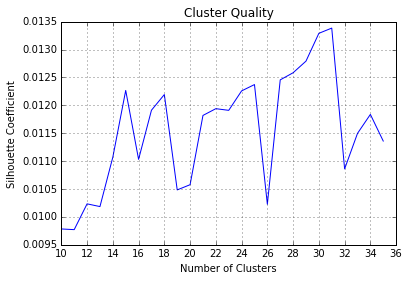

In [50]:
%matplotlib inline
compare_clusters(lyrics, range(10,36), .8, .0, stop) 

The results of comparing the number of clusters show spikes at 15, 18, 25, and 31 clusters. We'll take a look at each of these.

In [51]:
num_clusters = 15  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: oh, ooh, away, whoa, take, want, know, come, go, love, everyth, say,

Cluster 1 words: girl, want, boy, world, love, know, parti, like, one, time, goin, help,

Cluster 2 words: love, know, want, say, babi, give, never, one, make, heart, let, feel,

Cluster 3 words: dan, cest, tout, ell, plus, comm, mai, si, san, ça, vie, jai,

Cluster 4 words: time, one, love, day, like, heart, world, eye, never, nan, life, away,

Cluster 5 words: ich, und, der, nicht, ist, die, mich, ein, auf, wenn, mir, sie,

Cluster 6 words: babi, love, go, come, oh, know, want, girl, nan, let, caus, tell,

Cluster 7 words: lord, woman, god, prais, jesus, holi, love, chorus, merri, give, bless, one,

Cluster 8 words: come, wait, day, one, back, us, time, around, take, know, gone, way,

Cluster 9 words: amor, quiero, si, nunca, vida, vez, solo, tiempo, corazón, porqu, voy, ser,

Cluster 10 words: hey, stand, say, life, oh, love, better, well, home, want, go, know,

Cluster 11 

4     698
11    256
12    238
13    168
14    167
9     157
2     152
8      94
6      93
0      81
3      77
7      65
1      63
10     44
5      30
Name: clusters, dtype: int64

In [52]:
num_clusters = 18  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: whi, wait, danc, think, come, us, know, see, say, around, time, tell,

Cluster 1 words: nan, say, chorus, go, need, make, away, thing, tell, know, way, love,

Cluster 2 words: ich, und, der, nicht, ist, die, mich, ein, auf, wenn, mir, sie,

Cluster 3 words: dan, cest, tout, ell, plus, comm, mai, si, san, ça, vie, jai,

Cluster 4 words: eye, take, burn, hand, see, look, die, away, life, never, time, back,

Cluster 5 words: want, know, need, hold, thing, say, parti, love, caus, cri, tell, come,

Cluster 6 words: oh, ooh, know, away, whoa, take, love, way, everyth, like, never, make,

Cluster 7 words: nan, like, go, night, come, time, way, one, know, day, love, back,

Cluster 8 words: like, one, onli, could, feel, never, littl, ever, thing, know, alon, night,

Cluster 9 words: right, dream, free, see, follow, light, wrong, night, said, eye, make, way,

Cluster 10 words: amor, quiero, si, nunca, vida, vez, tiempo, solo, corazón, porqu, voy, ser,

Cl

7     667
17    211
4     203
12    164
10    161
8     143
1     104
16    101
0      97
9      88
15     84
3      77
6      76
11     53
13     47
5      46
14     31
2      30
Name: clusters, dtype: int64

In [53]:
num_clusters = 25
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: life, blood, save, lie, hell, death, god, end, eye, demon, earth, fall,

Cluster 1 words: one, day, nan, night, see, go, well, like, time, burn, know, never,

Cluster 2 words: hey, oh, say, daddi, go, love, life, well, woah, joe, sorri, like,

Cluster 3 words: babi, love, go, come, know, caus, oh, girl, time, pleas, nan, need,

Cluster 4 words: world, noth, believ, love, heart, eye, look, beat, see, chang, dream, time,

Cluster 5 words: run, nan, hide, time, help, away, go, said, place, nan, stop, street,

Cluster 6 words: dan, cest, tout, ell, plus, comm, mai, si, san, ça, vie, jai,

Cluster 7 words: love, know, one, never, say, babi, heart, oh, make, time, come, let,

Cluster 8 words: onli, one, night, alon, could, lone, know, see, love, feel, never, dream,

Cluster 9 words: come, feel, hous, around, us, one, know, day, never, take, back, way,

Cluster 10 words: lord, way, jesus, rememb, god, holi, walk, oh, love, bless, see, prais,

Cluster 1

1     524
13    319
7     146
4     133
0     127
24    110
23     97
18     94
8      79
6      77
3      70
10     66
19     65
17     64
20     52
15     50
5      49
21     47
9      45
11     33
14     31
12     30
16     30
2      29
22     16
Name: clusters, dtype: int64

In [54]:
num_clusters = 26  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: blood, lie, eye, life, save, fall, mind, light, breath, sky, end, god,

Cluster 1 words: everyth, see, light, eye, look, nan, end, come, chang, blue, hate, say,

Cluster 2 words: world, stop, love, round, go, noth, say, nan, pleas, make, around, life,

Cluster 3 words: beauti, christma, dream, close, merri, tomorrow, morn, pra, wish, bir, ei, jag,

Cluster 4 words: nan, hey, like, rock, go, well, back, time, man, know, make, take,

Cluster 5 words: oh, go, ooh, whoa, come, know, hey, say, life, nan, never, babi,

Cluster 6 words: lord, way, jesus, god, prais, holi, bless, rather, oh, love, chorus, may,

Cluster 7 words: nigga, like, shit, niggaz, fuck, yall, bitch, caus, know, wit, ass, make,

Cluster 8 words: ich, und, der, nicht, ist, die, mich, ein, auf, wenn, mir, sie,

Cluster 9 words: let, go, feel, rain, love, know, tell, right, make, time, good, away,

Cluster 10 words: amor, si, vida, corazón, nunca, vez, quiero, siento, porqu, alma, ve

4     401
17    243
3     163
0     161
15    112
19    106
21     93
7      93
23     83
10     79
25     76
22     73
5      69
11     66
12     65
20     64
2      61
6      55
24     55
16     49
13     47
9      45
1      33
18     31
14     30
8      30
Name: clusters, dtype: int64

In [55]:
num_clusters = 31  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: come, wait, around, hous, day, see, us, one, know, never, say, feel,

Cluster 1 words: littl, christma, bit, merri, everi, rock, day, go, need, thing, time, spoon,

Cluster 2 words: never, time, one, say, love, whi, know, away, thing, said, like, see,

Cluster 3 words: night, light, eye, see, danc, heart, look, dream, sky, dark, take, chorus,

Cluster 4 words: day, one, god, man, life, beat, around, know, good, like, talk, death,

Cluster 5 words: tiempo, si, ser, ay, hace, pra, queda, porqu, dio, dia, nunca, solo,

Cluster 6 words: want, know, need, love, thing, way, say, see, caus, cri, tell, never,

Cluster 7 words: mind, stay, late, make, time, tell, darl, mayb, right, twist, thing, nan,

Cluster 8 words: dan, cest, tout, ell, plus, comm, mai, si, san, ça, vie, jai,

Cluster 9 words: nigga, like, shit, fuck, niggaz, yall, caus, know, wit, bitch, nan, make,

Cluster 10 words: let, go, know, feel, nan, rain, make, like, love, come, life, time,

4     333
2     283
3     165
9     111
22    110
18    106
10    104
23     80
8      77
13     76
5      75
15     74
21     69
11     65
29     62
6      56
30     55
0      50
12     48
24     43
19     41
20     39
7      38
26     32
1      32
28     30
14     30
16     28
27     27
17     22
25     22
Name: clusters, dtype: int64

References

http://aimotion.blogspot.com/2011/12/machine-learning-with-python-meeting-tf.html

http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://github.com/grfiv/haiku_analysis/blob/master/Bag-of-Words%20Analysis%20Haiku%20(unsupervised,%20tf-idf%20%26%20kmeans,%20Silhouette).ipynb

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html#sklearn.metrics.pairwise.pairwise_distances

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

https://de.dariah.eu/tatom/working_with_text.html

http://brandonrose.org/clustering    

stemming: http://snowball.tartarus.org/texts/introduction.html

href="https://github.com/grfiv/haiku_analysis/blob/master/Bag-of-Words%20Analysis%20Haiku%20(unsupervised,%20tf-idf%20%26%20kmeans,%20Silhouette).ipynb">Haiku Analysis Project</a> and chapter 5 of the text: Python Data Science Cookbook.